In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset
import os
import copy
from tensorboardX import SummaryWriter
from PIL import Image
import torchvision.transforms as transforms

plt.ion()   # interactive mode
%matplotlib inline

In [2]:
class KDEFDataset(Dataset):
    def __init__(self, root='D:\\Research\\data\\KDEF_and_AKDEF\\KDEF', transforms_=None, idx=[]):
        self.transform = transforms_
        self.files = []

        for path, subdirs, files in os.walk(root):
            for name in files:
                self.files.append(os.path.join(path, name))
        
        self.files =  [self.files[i] for i in idx]
        self.classes = {
             "AF":0,
             "AN":1,
             "DI":2,
             "HA":3,
             "NE":4,
             "SA":5,
             "SU":6
        }
        
        for index in range(4900):
            filepath = self.files[index % len(self.files)]
            filename = filepath.split('\\')[-1]
            if filename[4:6] not in self.classes:
                print(filepath)

    def __getitem__(self, index):
        filepath = self.files[index % len(self.files)]

        filename = filepath.split('\\')[-1]
        img = self.transform(Image.open(filepath))
        label = self.classes[filename[4:6]]

        return img, label

    def __len__(self):
        return len(self.files)

Load Data
---------


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

idx = np.random.permutation(4900)
idx = {'val': idx[0:490], 'train': idx[490:]}

dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=8,
                                             shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(idx[x]) for x in ['train', 'val']}
class_names = 7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images


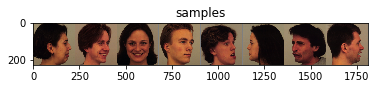

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title='samples')

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, dataloaders, writer=None, i=0,  num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/resnet_'+str(i)+'.pt')

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

Visualizing the model predictions

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [7]:
accuracies = []
index = list(np.random.permutation(4900))


for i in range(10):
    idx = {'val': index[490*i:490*(i+1)], 'train': index[:i*490]+index[((i+1)*490) -1:]}

    dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=32,
                                             shuffle=True)
              for x in ['train', 'val']}

    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, class_names)

    model_ft = model_ft.to(device)
 
    criterion = nn.CrossEntropyLoss()

    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)
    writer = SummaryWriter('./logs/resnet18_kfold_'+str(i))

    model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                     dataloaders, writer, i, num_epochs=20)
    
    accuracies.append(float(best_acc.data[0].cpu().numpy()))
    print("\n\n\n------------------------------------\n Accuracies ", accuracies)
    print("\n\n")

Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.89it/s]


train Loss: 1.5484 Acc: 0.4041


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s]


val Loss: 0.9966 Acc: 0.6367

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.6748 Acc: 0.7680


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.4985 Acc: 0.8224

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


train Loss: 0.3732 Acc: 0.8741


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


val Loss: 0.4217 Acc: 0.8612

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.88it/s]


train Loss: 0.2412 Acc: 0.9268


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.4254 Acc: 0.8469

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.89it/s]


train Loss: 0.1741 Acc: 0.9472


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.2987 Acc: 0.9082

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.88it/s]


train Loss: 0.1134 Acc: 0.9676


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.2820 Acc: 0.9061

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.0805 Acc: 0.9805


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s]


val Loss: 0.2445 Acc: 0.9122

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.94it/s]


train Loss: 0.0722 Acc: 0.9841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.55it/s]


val Loss: 0.2430 Acc: 0.9143

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.94it/s]


train Loss: 0.0648 Acc: 0.9882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.52it/s]


val Loss: 0.2354 Acc: 0.9184

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.0600 Acc: 0.9887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.2302 Acc: 0.9122

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


train Loss: 0.0598 Acc: 0.9887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


val Loss: 0.2278 Acc: 0.9224

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


train Loss: 0.0623 Acc: 0.9868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.2229 Acc: 0.9163

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


train Loss: 0.0552 Acc: 0.9891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.2259 Acc: 0.9184

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


train Loss: 0.0507 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.2258 Acc: 0.9224

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.0515 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.2289 Acc: 0.9204

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


train Loss: 0.0497 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s]


val Loss: 0.2333 Acc: 0.9143

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.89it/s]


train Loss: 0.0505 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


val Loss: 0.2263 Acc: 0.9184

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:14<00:00,  1.86it/s]


train Loss: 0.0488 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.2357 Acc: 0.9204

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:16<00:00,  1.80it/s]


train Loss: 0.0516 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.55it/s]


val Loss: 0.2252 Acc: 0.9184

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.0486 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.2298 Acc: 0.9204

Training complete in 26m 21s
Best val Acc: 0.922449


C:\Users\bikas\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number





------------------------------------
 Accuracies  [0.9224489795918368]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


train Loss: 1.5029 Acc: 0.4320


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.9232 Acc: 0.6694

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


train Loss: 0.6217 Acc: 0.7934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.5456 Acc: 0.7918

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.89it/s]


train Loss: 0.3459 Acc: 0.8839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.3769 Acc: 0.8633

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.88it/s]


train Loss: 0.2358 Acc: 0.9268


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.3020 Acc: 0.8857

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


train Loss: 0.1578 Acc: 0.9531


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.2451 Acc: 0.9061

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.89it/s]


train Loss: 0.1126 Acc: 0.9692


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.2100 Acc: 0.9143

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.0792 Acc: 0.9825


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.1871 Acc: 0.9388

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.0689 Acc: 0.9841


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1985 Acc: 0.9224

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.0675 Acc: 0.9834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


val Loss: 0.1859 Acc: 0.9327

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.88it/s]


train Loss: 0.0578 Acc: 0.9873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


val Loss: 0.1866 Acc: 0.9265

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.89it/s]


train Loss: 0.0546 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


val Loss: 0.1808 Acc: 0.9367

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.89it/s]


train Loss: 0.0526 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.1769 Acc: 0.9347

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.0470 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.55it/s]


val Loss: 0.1805 Acc: 0.9347

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.0532 Acc: 0.9887


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.1801 Acc: 0.9347

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.89it/s]


train Loss: 0.0513 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


val Loss: 0.1831 Acc: 0.9265

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.89it/s]


train Loss: 0.0535 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1830 Acc: 0.9306

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.89it/s]


train Loss: 0.0500 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1747 Acc: 0.9429

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.88it/s]


train Loss: 0.0505 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1764 Acc: 0.9367

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


train Loss: 0.0522 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.1703 Acc: 0.9449

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.0451 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.1806 Acc: 0.9327

Training complete in 26m 22s
Best val Acc: 0.944898



------------------------------------
 Accuracies  [0.9224489795918368, 0.9448979591836736]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


train Loss: 1.4579 Acc: 0.4506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.8520 Acc: 0.7102

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.89it/s]


train Loss: 0.6244 Acc: 0.7859


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.5471 Acc: 0.8041

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


train Loss: 0.3504 Acc: 0.8823


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.3632 Acc: 0.8776

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.2366 Acc: 0.9265


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.3354 Acc: 0.8918

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.1614 Acc: 0.9485


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.2839 Acc: 0.9020

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.1239 Acc: 0.9653


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.55it/s]


val Loss: 0.2678 Acc: 0.9122

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.0770 Acc: 0.9816


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.2148 Acc: 0.9204

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.0677 Acc: 0.9839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s]


val Loss: 0.2106 Acc: 0.9245

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.0599 Acc: 0.9880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.2095 Acc: 0.9245

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.0642 Acc: 0.9853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.2122 Acc: 0.9265

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.0528 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.1961 Acc: 0.9286

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.0513 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.54it/s]


val Loss: 0.1957 Acc: 0.9306

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.0511 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1990 Acc: 0.9306

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.0498 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.29it/s]


val Loss: 0.2155 Acc: 0.9224

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:14<00:00,  1.85it/s]


train Loss: 0.0496 Acc: 0.9900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.35it/s]


val Loss: 0.2025 Acc: 0.9286

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.0485 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.53it/s]


val Loss: 0.2020 Acc: 0.9265

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.0493 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.54it/s]


val Loss: 0.2049 Acc: 0.9327

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:14<00:00,  1.85it/s]


train Loss: 0.0486 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


val Loss: 0.2024 Acc: 0.9265

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


train Loss: 0.0481 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


val Loss: 0.1971 Acc: 0.9367

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


train Loss: 0.0480 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.35it/s]


val Loss: 0.1941 Acc: 0.9408

Training complete in 26m 17s
Best val Acc: 0.940816



------------------------------------
 Accuracies  [0.9224489795918368, 0.9448979591836736, 0.9408163265306123]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 1.4758 Acc: 0.4435


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.49it/s]


val Loss: 0.8338 Acc: 0.7184

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


train Loss: 0.6339 Acc: 0.7850


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.4827 Acc: 0.8204

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.3663 Acc: 0.8787


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.55it/s]


val Loss: 0.3813 Acc: 0.8490

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.94it/s]


train Loss: 0.2361 Acc: 0.9243


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.2820 Acc: 0.9082

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


train Loss: 0.1687 Acc: 0.9481


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


val Loss: 0.2614 Acc: 0.9102

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.1218 Acc: 0.9658


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.2583 Acc: 0.9061

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.88it/s]


train Loss: 0.0824 Acc: 0.9812


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]


val Loss: 0.1839 Acc: 0.9367

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.0699 Acc: 0.9844


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


val Loss: 0.1850 Acc: 0.9327

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:17<00:00,  1.79it/s]


train Loss: 0.0606 Acc: 0.9891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


val Loss: 0.1774 Acc: 0.9429

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:15<00:00,  1.82it/s]


train Loss: 0.0618 Acc: 0.9878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.32it/s]


val Loss: 0.1812 Acc: 0.9408

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:14<00:00,  1.85it/s]


train Loss: 0.0607 Acc: 0.9882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


val Loss: 0.1783 Acc: 0.9367

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:14<00:00,  1.86it/s]


train Loss: 0.0559 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.22it/s]


val Loss: 0.1735 Acc: 0.9306

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


train Loss: 0.0498 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.1726 Acc: 0.9429

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.89it/s]


train Loss: 0.0526 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.1738 Acc: 0.9408

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.89it/s]


train Loss: 0.0531 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.1753 Acc: 0.9367

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.89it/s]


train Loss: 0.0504 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1781 Acc: 0.9306

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


train Loss: 0.0508 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.41it/s]


val Loss: 0.1732 Acc: 0.9408

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:15<00:00,  1.82it/s]


train Loss: 0.0514 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.40it/s]


val Loss: 0.1735 Acc: 0.9388

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:15<00:00,  1.84it/s]


train Loss: 0.0489 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


val Loss: 0.1722 Acc: 0.9388

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.88it/s]


train Loss: 0.0499 Acc: 0.9900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


val Loss: 0.1734 Acc: 0.9388

Training complete in 26m 39s
Best val Acc: 0.942857



------------------------------------
 Accuracies  [0.9224489795918368, 0.9448979591836736, 0.9408163265306123, 0.942857142857143]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


train Loss: 1.5112 Acc: 0.4249


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.52it/s]


val Loss: 0.9738 Acc: 0.6469

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.92it/s]


train Loss: 0.6611 Acc: 0.7782


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.5578 Acc: 0.7878

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


train Loss: 0.3676 Acc: 0.8794


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.46it/s]


val Loss: 0.4207 Acc: 0.8531

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


train Loss: 0.2516 Acc: 0.9154


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


val Loss: 0.3727 Acc: 0.8694

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.1585 Acc: 0.9546


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.3070 Acc: 0.8898

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


train Loss: 0.1163 Acc: 0.9687


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


val Loss: 0.2494 Acc: 0.9204

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


train Loss: 0.0787 Acc: 0.9807


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.31it/s]


val Loss: 0.2349 Acc: 0.9224

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.88it/s]


train Loss: 0.0661 Acc: 0.9853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.2497 Acc: 0.9204

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.87it/s]


train Loss: 0.0615 Acc: 0.9868


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.2307 Acc: 0.9245

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


train Loss: 0.0575 Acc: 0.9900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.54it/s]


val Loss: 0.2368 Acc: 0.9265

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.89it/s]


train Loss: 0.0524 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.2236 Acc: 0.9367

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.88it/s]


train Loss: 0.0563 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


val Loss: 0.2283 Acc: 0.9347

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:14<00:00,  1.86it/s]


train Loss: 0.0473 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.2183 Acc: 0.9408

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:05<00:00,  2.10it/s]


train Loss: 0.0496 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.86it/s]


val Loss: 0.2246 Acc: 0.9265

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:04<00:00,  2.13it/s]


train Loss: 0.0457 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.01it/s]


val Loss: 0.2227 Acc: 0.9347

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:03<00:00,  2.17it/s]


train Loss: 0.0497 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


val Loss: 0.2295 Acc: 0.9327

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:07<00:00,  2.06it/s]


train Loss: 0.0470 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


val Loss: 0.2255 Acc: 0.9327

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.0473 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.69it/s]


val Loss: 0.2463 Acc: 0.9224

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


train Loss: 0.0502 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.75it/s]


val Loss: 0.2262 Acc: 0.9327

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:07<00:00,  2.04it/s]


train Loss: 0.0451 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.66it/s]


val Loss: 0.2357 Acc: 0.9306

Training complete in 25m 42s
Best val Acc: 0.940816



------------------------------------
 Accuracies  [0.9224489795918368, 0.9448979591836736, 0.9408163265306123, 0.942857142857143, 0.9408163265306123]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:07<00:00,  2.05it/s]


train Loss: 1.5450 Acc: 0.4088


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


val Loss: 0.9077 Acc: 0.6959

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


train Loss: 0.6646 Acc: 0.7710


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.60it/s]


val Loss: 0.5505 Acc: 0.8265

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


train Loss: 0.3705 Acc: 0.8785


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.67it/s]


val Loss: 0.4044 Acc: 0.8490

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


train Loss: 0.2466 Acc: 0.9220


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.61it/s]


val Loss: 0.2502 Acc: 0.9102

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


train Loss: 0.1659 Acc: 0.9456


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.59it/s]


val Loss: 0.2736 Acc: 0.8898

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


train Loss: 0.1163 Acc: 0.9671


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.2173 Acc: 0.9102

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.94it/s]


train Loss: 0.0762 Acc: 0.9834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


val Loss: 0.1631 Acc: 0.9429

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


train Loss: 0.0674 Acc: 0.9846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.67it/s]


val Loss: 0.1645 Acc: 0.9469

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


train Loss: 0.0667 Acc: 0.9853


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.66it/s]


val Loss: 0.1584 Acc: 0.9510

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:17<00:00,  1.79it/s]


train Loss: 0.0592 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.15it/s]


val Loss: 0.1569 Acc: 0.9490

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:15<00:00,  1.84it/s]


train Loss: 0.0566 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.51it/s]


val Loss: 0.1516 Acc: 0.9469

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:07<00:00,  2.04it/s]


train Loss: 0.0522 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.77it/s]


val Loss: 0.1493 Acc: 0.9469

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.02it/s]


train Loss: 0.0504 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.69it/s]


val Loss: 0.1493 Acc: 0.9449

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.02it/s]


train Loss: 0.0512 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.69it/s]


val Loss: 0.1503 Acc: 0.9429

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.89it/s]


train Loss: 0.0459 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


val Loss: 0.1499 Acc: 0.9510

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:19<00:00,  1.74it/s]


train Loss: 0.0485 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.58it/s]


val Loss: 0.1514 Acc: 0.9449

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


train Loss: 0.0468 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.62it/s]


val Loss: 0.1526 Acc: 0.9490

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.23it/s]


train Loss: 0.0488 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


val Loss: 0.1496 Acc: 0.9551

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.24it/s]


train Loss: 0.0486 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


val Loss: 0.1518 Acc: 0.9449

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.24it/s]


train Loss: 0.0509 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s]


val Loss: 0.1479 Acc: 0.9469

Training complete in 25m 18s
Best val Acc: 0.955102



------------------------------------
 Accuracies  [0.9224489795918368, 0.9448979591836736, 0.9408163265306123, 0.942857142857143, 0.9408163265306123, 0.9551020408163267]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


train Loss: 1.5186 Acc: 0.4156


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.15it/s]


val Loss: 0.8963 Acc: 0.7184

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


train Loss: 0.6470 Acc: 0.7723


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s]


val Loss: 0.5056 Acc: 0.8224

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:02<00:00,  2.20it/s]


train Loss: 0.3887 Acc: 0.8726


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.07it/s]


val Loss: 0.4041 Acc: 0.8735

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:04<00:00,  2.15it/s]


train Loss: 0.2447 Acc: 0.9193


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


val Loss: 0.2992 Acc: 0.8878

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


train Loss: 0.1751 Acc: 0.9429


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s]


val Loss: 0.3119 Acc: 0.8898

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.26it/s]


train Loss: 0.1256 Acc: 0.9633


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s]


val Loss: 0.2676 Acc: 0.9000

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.30it/s]


train Loss: 0.0802 Acc: 0.9800


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s]


val Loss: 0.2052 Acc: 0.9245

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.31it/s]


train Loss: 0.0702 Acc: 0.9855


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.11it/s]


val Loss: 0.2028 Acc: 0.9245

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.32it/s]


train Loss: 0.0669 Acc: 0.9866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.27it/s]


val Loss: 0.2080 Acc: 0.9224

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.26it/s]


train Loss: 0.0664 Acc: 0.9866


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


val Loss: 0.1888 Acc: 0.9286

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:59<00:00,  2.30it/s]


train Loss: 0.0598 Acc: 0.9893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.00it/s]


val Loss: 0.1926 Acc: 0.9286

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:03<00:00,  2.18it/s]


train Loss: 0.0569 Acc: 0.9884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.93it/s]


val Loss: 0.1856 Acc: 0.9347

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


train Loss: 0.0477 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


val Loss: 0.1892 Acc: 0.9327

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


train Loss: 0.0536 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.20it/s]


val Loss: 0.1860 Acc: 0.9286

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


train Loss: 0.0491 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


val Loss: 0.1858 Acc: 0.9327

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


train Loss: 0.0526 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]


val Loss: 0.1883 Acc: 0.9347

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.26it/s]


train Loss: 0.0502 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.20it/s]


val Loss: 0.1865 Acc: 0.9265

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.30it/s]


train Loss: 0.0463 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


val Loss: 0.1871 Acc: 0.9347

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


train Loss: 0.0492 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]


val Loss: 0.1895 Acc: 0.9306

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


train Loss: 0.0502 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s]


val Loss: 0.1894 Acc: 0.9306

Training complete in 21m 58s
Best val Acc: 0.934694



------------------------------------
 Accuracies  [0.9224489795918368, 0.9448979591836736, 0.9408163265306123, 0.942857142857143, 0.9408163265306123, 0.9551020408163267, 0.9346938775510205]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


train Loss: 1.5431 Acc: 0.4079


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s]


val Loss: 0.9062 Acc: 0.6980

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


train Loss: 0.6566 Acc: 0.7773


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.18it/s]


val Loss: 0.5244 Acc: 0.8143

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


train Loss: 0.3654 Acc: 0.8812


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.28it/s]


val Loss: 0.4179 Acc: 0.8347

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


train Loss: 0.2405 Acc: 0.9247


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s]


val Loss: 0.3138 Acc: 0.8796

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


train Loss: 0.1621 Acc: 0.9506


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


val Loss: 0.2863 Acc: 0.8980

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:02<00:00,  2.22it/s]


train Loss: 0.1328 Acc: 0.9628


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


val Loss: 0.2226 Acc: 0.9224

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.26it/s]


train Loss: 0.0809 Acc: 0.9819


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


val Loss: 0.1947 Acc: 0.9306

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


train Loss: 0.0716 Acc: 0.9839


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s]


val Loss: 0.1861 Acc: 0.9388

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


train Loss: 0.0694 Acc: 0.9846


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.26it/s]


val Loss: 0.1867 Acc: 0.9388

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


train Loss: 0.0615 Acc: 0.9878


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s]


val Loss: 0.1821 Acc: 0.9286

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


train Loss: 0.0594 Acc: 0.9875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s]


val Loss: 0.1777 Acc: 0.9327

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


train Loss: 0.0606 Acc: 0.9893


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


val Loss: 0.1817 Acc: 0.9347

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


train Loss: 0.0563 Acc: 0.9898


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


val Loss: 0.1800 Acc: 0.9388

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


train Loss: 0.0587 Acc: 0.9884


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.25it/s]


val Loss: 0.1794 Acc: 0.9347

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


train Loss: 0.0514 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s]


val Loss: 0.1771 Acc: 0.9347

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


train Loss: 0.0562 Acc: 0.9882


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.23it/s]


val Loss: 0.1736 Acc: 0.9429

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.29it/s]


train Loss: 0.0565 Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.10it/s]


val Loss: 0.1712 Acc: 0.9388

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.26it/s]


train Loss: 0.0538 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


val Loss: 0.1804 Acc: 0.9367

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.28it/s]


train Loss: 0.0524 Acc: 0.9905


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


val Loss: 0.1749 Acc: 0.9367

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.26it/s]


train Loss: 0.0511 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s]


val Loss: 0.1763 Acc: 0.9347

Training complete in 21m 53s
Best val Acc: 0.942857



------------------------------------
 Accuracies  [0.9224489795918368, 0.9448979591836736, 0.9408163265306123, 0.942857142857143, 0.9408163265306123, 0.9551020408163267, 0.9346938775510205, 0.942857142857143]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.24it/s]


train Loss: 1.5346 Acc: 0.4218


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s]


val Loss: 0.9575 Acc: 0.6408

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:02<00:00,  2.22it/s]


train Loss: 0.6722 Acc: 0.7698


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.99it/s]


val Loss: 0.4808 Acc: 0.8306

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.24it/s]


train Loss: 0.3704 Acc: 0.8746


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


val Loss: 0.4195 Acc: 0.8633

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.24it/s]


train Loss: 0.2415 Acc: 0.9202


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.78it/s]


val Loss: 0.4002 Acc: 0.8469

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.23it/s]


train Loss: 0.1689 Acc: 0.9490


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s]


val Loss: 0.2822 Acc: 0.9020

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:02<00:00,  2.20it/s]


train Loss: 0.1317 Acc: 0.9592


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


val Loss: 0.3036 Acc: 0.8918

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.23it/s]


train Loss: 0.0873 Acc: 0.9762


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s]


val Loss: 0.2181 Acc: 0.9224

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.25it/s]


train Loss: 0.0726 Acc: 0.9834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.14it/s]


val Loss: 0.2216 Acc: 0.9143

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.26it/s]


train Loss: 0.0684 Acc: 0.9855


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


val Loss: 0.2016 Acc: 0.9184

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:03<00:00,  2.17it/s]


train Loss: 0.0649 Acc: 0.9862


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.1946 Acc: 0.9245

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:05<00:00,  2.11it/s]


train Loss: 0.0621 Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.82it/s]


val Loss: 0.1882 Acc: 0.9306

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:04<00:00,  2.15it/s]


train Loss: 0.0549 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.86it/s]


val Loss: 0.1841 Acc: 0.9327

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:04<00:00,  2.16it/s]


train Loss: 0.0528 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.80it/s]


val Loss: 0.1848 Acc: 0.9327

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:05<00:00,  2.11it/s]


train Loss: 0.0542 Acc: 0.9907


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s]


val Loss: 0.1869 Acc: 0.9367

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:05<00:00,  2.10it/s]


train Loss: 0.0518 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.86it/s]


val Loss: 0.1831 Acc: 0.9286

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:03<00:00,  2.16it/s]


train Loss: 0.0547 Acc: 0.9875


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.94it/s]


val Loss: 0.1826 Acc: 0.9286

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:03<00:00,  2.17it/s]


train Loss: 0.0516 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.94it/s]


val Loss: 0.1846 Acc: 0.9286

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:03<00:00,  2.19it/s]


train Loss: 0.0521 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.78it/s]


val Loss: 0.1874 Acc: 0.9306

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:03<00:00,  2.17it/s]


train Loss: 0.0540 Acc: 0.9891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.85it/s]


val Loss: 0.1833 Acc: 0.9286

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:02<00:00,  2.20it/s]


train Loss: 0.0536 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.99it/s]


val Loss: 0.1822 Acc: 0.9367

Training complete in 22m 49s
Best val Acc: 0.936735



------------------------------------
 Accuracies  [0.9224489795918368, 0.9448979591836736, 0.9408163265306123, 0.942857142857143, 0.9408163265306123, 0.9551020408163267, 0.9346938775510205, 0.942857142857143, 0.9367346938775512]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:02<00:00,  2.20it/s]


train Loss: 1.5046 Acc: 0.4272


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.94it/s]


val Loss: 0.9167 Acc: 0.6714

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:04<00:00,  2.14it/s]


train Loss: 0.6556 Acc: 0.7776


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.97it/s]


val Loss: 0.4685 Acc: 0.8510

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:03<00:00,  2.18it/s]


train Loss: 0.3808 Acc: 0.8728


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.88it/s]


val Loss: 0.3260 Acc: 0.8918

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:03<00:00,  2.18it/s]


train Loss: 0.2503 Acc: 0.9170


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.88it/s]


val Loss: 0.2967 Acc: 0.8980

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:03<00:00,  2.18it/s]


train Loss: 0.1636 Acc: 0.9517


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.89it/s]


val Loss: 0.2463 Acc: 0.9041

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:03<00:00,  2.18it/s]


train Loss: 0.1265 Acc: 0.9642


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.98it/s]


val Loss: 0.2248 Acc: 0.9286

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:03<00:00,  2.18it/s]


train Loss: 0.0733 Acc: 0.9834


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.95it/s]


val Loss: 0.2106 Acc: 0.9204

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:02<00:00,  2.20it/s]


train Loss: 0.0647 Acc: 0.9880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.96it/s]


val Loss: 0.2022 Acc: 0.9224

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:02<00:00,  2.20it/s]


train Loss: 0.0636 Acc: 0.9880


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.94it/s]


val Loss: 0.2027 Acc: 0.9265

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:04<00:00,  2.16it/s]


train Loss: 0.0612 Acc: 0.9891


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.07it/s]


val Loss: 0.2014 Acc: 0.9306

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.25it/s]


train Loss: 0.0564 Acc: 0.9900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.24it/s]


val Loss: 0.2030 Acc: 0.9286

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


train Loss: 0.0535 Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.22it/s]


val Loss: 0.1950 Acc: 0.9306

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.25it/s]


train Loss: 0.0505 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


val Loss: 0.1947 Acc: 0.9306

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.26it/s]


train Loss: 0.0541 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.19it/s]


val Loss: 0.1904 Acc: 0.9306

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.25it/s]


train Loss: 0.0494 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


val Loss: 0.1939 Acc: 0.9347

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.25it/s]


train Loss: 0.0503 Acc: 0.9900


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.20it/s]


val Loss: 0.1914 Acc: 0.9306

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.25it/s]


train Loss: 0.0560 Acc: 0.9873


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.17it/s]


val Loss: 0.2018 Acc: 0.9286

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.25it/s]


train Loss: 0.0519 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.20it/s]


val Loss: 0.2026 Acc: 0.9327

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:01<00:00,  2.25it/s]


train Loss: 0.0463 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


val Loss: 0.1995 Acc: 0.9265

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [01:00<00:00,  2.27it/s]


train Loss: 0.0486 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.21it/s]


val Loss: 0.1876 Acc: 0.9367

Training complete in 22m 31s
Best val Acc: 0.936735



------------------------------------
 Accuracies  [0.9224489795918368, 0.9448979591836736, 0.9408163265306123, 0.942857142857143, 0.9408163265306123, 0.9551020408163267, 0.9346938775510205, 0.942857142857143, 0.9367346938775512, 0.9367346938775512]





# Load and test the model

In [11]:
model_ft.load_state_dict(torch.load('saved/resnet_0.pt'))
model_ft.eval()

dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=index), batch_size=1,
                                             shuffle=True)
              for x in ['train', 'val']}

In [12]:
import imageio
total = 0
correct = 0

classes = {
    0 : "AF",
    1 : "AN",
    2 : "DI",
    3 : "HA",
    4 : "NE",
    5 : "SA",
    6 : "SU"
}

for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)


    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    
    total+=1
    if labels.data[0].cpu().numpy() == preds.data[0].cpu().numpy():
        correct+=1
    else:
        # save the image
        img = inputs[0].cpu().numpy()
        img = np.ascontiguousarray(img.transpose(1,2,0))
        imageio.imwrite(str(total)+'.jpg', img)
        
        print("image no ", str(total), "  original class : ", classes[int(labels.data[0].cpu().numpy())], "  predicted class: ", classes[int(preds.data[0].cpu().numpy())])

print(correct, total)

  0%|                                                                                         | 0/4900 [00:00<?, ?it/s]

image no  4   original class :  AF   predicted class:  SU
image no  5   original class :  AF   predicted class:  SA


  1%|▉                                                                               | 56/4900 [00:01<01:41, 47.80it/s]

image no  58   original class :  DI   predicted class:  SA


  1%|█▏                                                                              | 71/4900 [00:01<01:37, 49.31it/s]

image no  79   original class :  SA   predicted class:  AF


  2%|█▉                                                                             | 118/4900 [00:02<01:26, 55.50it/s]

image no  125   original class :  SU   predicted class:  AF


  9%|███████▏                                                                       | 444/4900 [00:06<01:06, 66.77it/s]

image no  451   original class :  AN   predicted class:  SA


 12%|█████████▋                                                                     | 597/4900 [00:08<01:03, 67.67it/s]

image no  603   original class :  SA   predicted class:  NE


 13%|██████████▎                                                                    | 643/4900 [00:09<01:02, 67.77it/s]

image no  648   original class :  AF   predicted class:  SU


 14%|███████████▎                                                                   | 698/4900 [00:10<01:01, 67.89it/s]

image no  705   original class :  SA   predicted class:  DI


 15%|███████████▌                                                                   | 714/4900 [00:10<01:01, 67.85it/s]

image no  719   original class :  AF   predicted class:  SU


 16%|████████████▍                                                                  | 775/4900 [00:11<01:00, 67.92it/s]

image no  782   original class :  AF   predicted class:  DI


 17%|█████████████▊                                                                 | 853/4900 [00:12<00:59, 68.10it/s]

image no  858   original class :  SA   predicted class:  AF


 20%|███████████████▌                                                               | 964/4900 [00:14<00:57, 68.44it/s]

image no  968   original class :  NE   predicted class:  SU


 21%|████████████████▎                                                             | 1028/4900 [00:15<00:56, 68.49it/s]

image no  1033   original class :  AF   predicted class:  SU


 22%|█████████████████                                                             | 1074/4900 [00:15<00:55, 68.53it/s]

image no  1078   original class :  NE   predicted class:  AN


 24%|██████████████████▍                                                           | 1162/4900 [00:16<00:54, 68.74it/s]

image no  1163   original class :  NE   predicted class:  SA


 28%|██████████████████████▏                                                       | 1396/4900 [00:20<00:50, 69.44it/s]

image no  1402   original class :  AF   predicted class:  SU


 30%|███████████████████████▌                                                      | 1484/4900 [00:21<00:49, 69.56it/s]

image no  1489   original class :  DI   predicted class:  AF


 32%|████████████████████████▊                                                     | 1556/4900 [00:22<00:48, 69.60it/s]

image no  1563   original class :  AF   predicted class:  SA


 32%|█████████████████████████                                                     | 1572/4900 [00:22<00:47, 69.61it/s]

image no  1578   original class :  DI   predicted class:  AF


 35%|███████████████████████████▋                                                  | 1738/4900 [00:24<00:45, 69.72it/s]

image no  1746   original class :  SA   predicted class:  AF


 36%|███████████████████████████▊                                                  | 1746/4900 [00:25<00:45, 69.68it/s]

image no  1747   original class :  HA   predicted class:  NE


 36%|███████████████████████████▉                                                  | 1754/4900 [00:25<00:45, 69.62it/s]

image no  1757   original class :  AF   predicted class:  SU


 36%|████████████████████████████▏                                                 | 1769/4900 [00:25<00:44, 69.60it/s]

image no  1776   original class :  DI   predicted class:  AF


 38%|█████████████████████████████▌                                                | 1854/4900 [00:26<00:43, 69.54it/s]

image no  1858   original class :  SA   predicted class:  AF


 40%|███████████████████████████████▎                                              | 1967/4900 [00:28<00:42, 69.69it/s]

image no  1971   original class :  NE   predicted class:  DI


 41%|███████████████████████████████▋                                              | 1991/4900 [00:28<00:41, 69.68it/s]

image no  1994   original class :  SU   predicted class:  AF


 43%|█████████████████████████████████▋                                            | 2117/4900 [00:30<00:39, 69.77it/s]

image no  2121   original class :  SA   predicted class:  AF


 44%|█████████████████████████████████▉                                            | 2133/4900 [00:30<00:39, 69.73it/s]

image no  2140   original class :  DI   predicted class:  AF


 46%|███████████████████████████████████▌                                          | 2235/4900 [00:32<00:38, 69.77it/s]

image no  2237   original class :  SA   predicted class:  DI


 46%|███████████████████████████████████▋                                          | 2243/4900 [00:32<00:38, 69.72it/s]

image no  2245   original class :  SA   predicted class:  NE


 49%|██████████████████████████████████████▏                                       | 2398/4900 [00:34<00:35, 69.76it/s]

image no  2400   original class :  SA   predicted class:  AF


 49%|██████████████████████████████████████▍                                       | 2414/4900 [00:34<00:35, 69.72it/s]

image no  2415   original class :  AF   predicted class:  SU


 50%|███████████████████████████████████████▏                                      | 2462/4900 [00:35<00:34, 69.74it/s]

image no  2468   original class :  AN   predicted class:  AF


 58%|█████████████████████████████████████████████▌                                | 2863/4900 [00:40<00:29, 70.01it/s]

image no  2866   original class :  AF   predicted class:  AN


 59%|██████████████████████████████████████████████▏                               | 2901/4900 [00:41<00:28, 69.91it/s]

image no  2904   original class :  AF   predicted class:  SU


 62%|████████████████████████████████████████████████▍                             | 3043/4900 [00:43<00:26, 69.75it/s]

image no  3051   original class :  SA   predicted class:  NE


 64%|██████████████████████████████████████████████████                            | 3144/4900 [00:45<00:25, 69.74it/s]

image no  3146   original class :  AF   predicted class:  SU


 65%|██████████████████████████████████████████████████▋                           | 3183/4900 [00:45<00:24, 69.66it/s]

image no  3186   original class :  AF   predicted class:  SU


 66%|███████████████████████████████████████████████████▎                          | 3221/4900 [00:46<00:24, 69.61it/s]

image no  3223   original class :  SA   predicted class:  AF


 66%|███████████████████████████████████████████████████▊                          | 3258/4900 [00:46<00:23, 69.54it/s]

image no  3265   original class :  SA   predicted class:  NE


 71%|███████████████████████████████████████████████████████▋                      | 3499/4900 [00:50<00:20, 69.54it/s]

image no  3503   original class :  AF   predicted class:  SU


 76%|███████████████████████████████████████████████████████████▌                  | 3739/4900 [00:53<00:16, 69.50it/s]

image no  3742   original class :  AN   predicted class:  NE


 77%|███████████████████████████████████████████████████████████▋                  | 3753/4900 [00:54<00:16, 69.44it/s]

image no  3755   original class :  AF   predicted class:  SU


 77%|████████████████████████████████████████████████████████████▍                 | 3797/4900 [00:54<00:15, 69.38it/s]

image no  3799   original class :  DI   predicted class:  SA


 81%|███████████████████████████████████████████████████████████████▏              | 3972/4900 [00:57<00:13, 69.29it/s]

image no  3979   original class :  SU   predicted class:  AF


 83%|████████████████████████████████████████████████████████████████▊             | 4071/4900 [00:58<00:11, 69.26it/s]

image no  4078   original class :  SA   predicted class:  AF


 84%|█████████████████████████████████████████████████████████████████▎            | 4103/4900 [00:59<00:11, 69.26it/s]

image no  4105   original class :  SA   predicted class:  DI


 84%|█████████████████████████████████████████████████████████████████▍            | 4110/4900 [00:59<00:11, 69.23it/s]

image no  4111   original class :  AF   predicted class:  DI


 84%|█████████████████████████████████████████████████████████████████▋            | 4125/4900 [00:59<00:11, 69.21it/s]

image no  4129   original class :  SU   predicted class:  AF


 85%|██████████████████████████████████████████████████████████████████▎           | 4167/4900 [01:00<00:10, 69.15it/s]

image no  4172   original class :  AF   predicted class:  SA


 86%|███████████████████████████████████████████████████████████████████▍          | 4237/4900 [01:01<00:09, 69.16it/s]

image no  4245   original class :  NE   predicted class:  DI


 87%|████████████████████████████████████████████████████████████████████▏         | 4281/4900 [01:01<00:08, 69.11it/s]

image no  4282   original class :  AF   predicted class:  SA


 89%|█████████████████████████████████████████████████████████████████████▋        | 4378/4900 [01:03<00:07, 69.06it/s]

image no  4383   original class :  SA   predicted class:  SU


 89%|█████████████████████████████████████████████████████████████████████▊        | 4385/4900 [01:03<00:07, 69.05it/s]

image no  4386   original class :  SU   predicted class:  AF


 90%|██████████████████████████████████████████████████████████████████████▏       | 4407/4900 [01:03<00:07, 69.01it/s]

image no  4409   original class :  SA   predicted class:  DI


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4706/4900 [01:08<00:02, 69.04it/s]

image no  4714   original class :  AN   predicted class:  NE


 97%|████████████████████████████████████████████████████████████████████████████  | 4777/4900 [01:09<00:01, 69.04it/s]

image no  4783   original class :  AF   predicted class:  SU


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4858/4900 [01:10<00:00, 68.99it/s]

image no  4862   original class :  AF   predicted class:  NE


100%|██████████████████████████████████████████████████████████████████████████████| 4900/4900 [01:11<00:00, 68.94it/s]


4841 4900
